In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import mlflow
from mlflow import pyfunc
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import numpy as np


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/karthikeyans/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/karthikeyans/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/karthikeyans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/karthikeyans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import matplotlib.pyplot as plt

Importing the dataset

In [3]:
# Read the CSV file
df = pd.read_csv("/Users/karthikeyans/kdemo/lib/Recommendation/bookDataProcessed.csv")

In [4]:
df.head(2)

,title,author,imageURL,genre,noOfPages,publicationDate,rating,noOfPeopleRated,description,bookID
0,Talking to Strangers: What We Should Know Abou...,Malcolm Gladwell,https://images-na.ssl-images-amazon.com/images...,Non - fiction,"388 pages, Hardcover","First published September 10, 2019",4.02,288765,"Malcolm Gladwell, host of the podcast Revision...",1
1,The Alchemist,Paulo Coelho,https://images-na.ssl-images-amazon.com/images...,Non - fiction,"182 pages, Paperback","First published January 1, 1988",3.91,3019919,"Combining magic, mysticism, wisdom, and wonder...",2


In [5]:
ratings = df['rating'].sort_values(ascending=False)
ratings

220    5.00
114    5.00
89     5.00
83     4.89
81     4.80
       ... 
226    0.00
225    0.00
224    0.00
343    0.00
139    0.00
Name: rating, Length: 611, dtype: float64

Text proccessing

In [6]:
# Remove punctuation
def remove_punctuation(text):
    punctuation_list = string.punctuation + "-"
    return text.translate(str.maketrans(' ',' ',punctuation_list))

In [7]:
df["title_cleaned"] = df["title"].apply(lambda x: remove_punctuation(x))
df["description_cleaned"] = df["description"].apply(lambda x : remove_punctuation(x))
df["cleaned_genre"] = df['genre'].apply(lambda x : remove_punctuation(x))

df["filtered_features"] = df["title_cleaned"] + ' ' + df["description_cleaned"] + ' ' + df["genre"]


In [8]:
df_lookup = df.copy()

In [9]:
class LemmaTokenizer (object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [10]:
# Create vectorizer of ngrams using 
tfv = TfidfVectorizer( ngram_range=(1,1), analyzer='word', stop_words='english',tokenizer=LemmaTokenizer())

# Fit vectorizer on processed description
sparse_vector_matrix = tfv.fit_transform(df["filtered_features"] )

/Users/karthikeyans/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/karthikeyans/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [11]:
from sklearn.neighbors import NearestNeighbors

# Build KNN model   
knn_model = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine')  
knn_model.fit(sparse_vector_matrix) 

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

Build prediction function

In [12]:
def recommendation(model_input, tfv=tfv,df_lookup=df_lookup):
    # Process the events as before
    input_df = pd.DataFrame([model_input], columns=['description', 'goalName','beginDate','endDate'])
    # Convert 'description' column to string
    input_df['description'] = input_df['description'].astype(str)
    input_df['goalName'] = input_df['goalName'].astype(str)
    
    input_df['decription'] = input_df['description'].apply(lambda x: ' '.join(x.split()))
    input_df['goalname'] = input_df['goalName'].apply(lambda x: ' '.join(x.split()))
    input_df['bag_of_words'] = input_df['decription'] + ' ' + input_df['goalname']
    
    inputted_vector = tfv.transform(input_df['bag_of_words'])
    
    # Find k-nearest neighbors
    distances, indices = knn_model.kneighbors(inputted_vector)

    # Assuming distances is a 2D array where each row contains distances to the nearest neighbors for a single input
    distances_flattened = distances.flatten()

    plt.hist(distances_flattened, bins=20)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Histogram of Distances to Nearest Neighbors')
    plt.show()

    # Assuming distances is a 2D array where each row contains distances to the nearest neighbors for a single input
    for i, dist in enumerate(distances):
        plt.scatter(range(len(dist)), dist, label=f'Input {i+1}')

    plt.xlabel('Neighbor Index')
    plt.ylabel('Distance')
    plt.title('Scatter Plot of Distances to Nearest Neighbors')
    plt.legend()
    plt.show()
    # Assuming distances is a 2D array where each row contains distances to the nearest neighbors for a single input
    sns.heatmap(distances, cmap='viridis')
    plt.xlabel('Neighbor Index')
    plt.ylabel('Input Index')
    plt.title('Heatmap of Distances to Nearest Neighbors')
    plt.show()

    # Get the top recommended events
    top_event_indices = indices[0][:10]  # Adjust the number of recommendations as needed
    
    #initializing the empty list of recommended repo
    recommended_events = df_lookup.loc[top_event_indices, ['title','rating','author']]
    
    recommended_books_sorted = recommended_events.sort_values(by="rating", ascending=False)

    # Plot the distances of each recommended book to the input
    plt.figure(figsize=(10, 6))
    plt.bar(recommended_books_sorted['title'], distances[0])
    plt.xlabel('Recommended Book')
    plt.ylabel('Distance to Input')
    plt.title('Distances of Recommended Books to Input')
    plt.xticks(rotation=90) # Rotate x-axis labels for better readability
    plt.show() 
    
    top3 = recommended_books_sorted.head(5)
    print(type(top3))

    return top3


Defining custom model for Event Recommendation

In [13]:
class bookPopularityRecommendation(pyfunc.PythonModel):
    ## defining objects needed for prediction
    def __init__(self,
                tfv,
                sparse_vector_matrix,
                df_lookup,
                recommendation):
        
        ## setting up all needed objects
        self.tfv = tfv
        self.sparse_vector_matrix = sparse_vector_matrix
        self.df_lookup = df_lookup
        self.recommendation = recommendation
        
    ## define function with processing and feeding data into prediction at the end
    def predict(self,context,model_input):
        output_df = self.recommendation(model_input)
        return output_df.to_dict('records')
    
    

Testing the prediction class

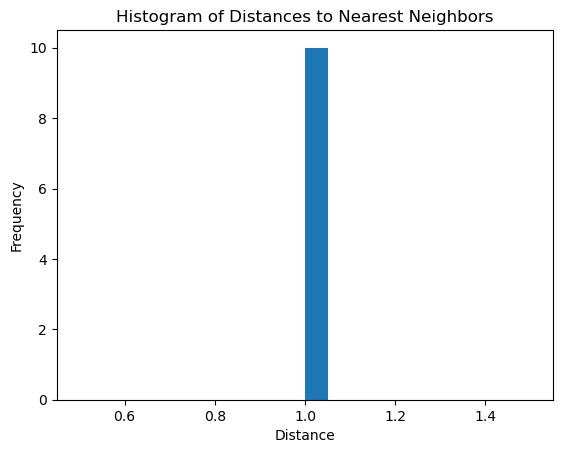

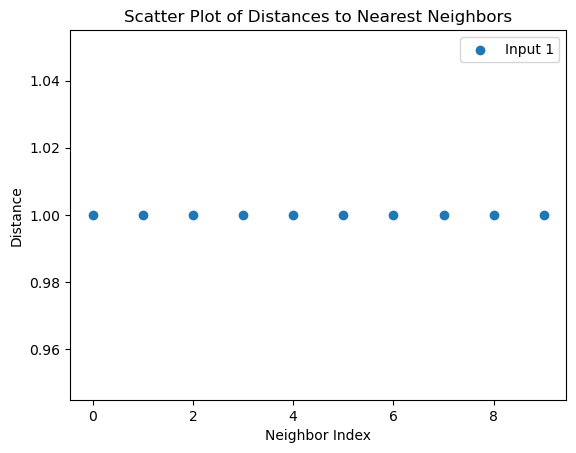

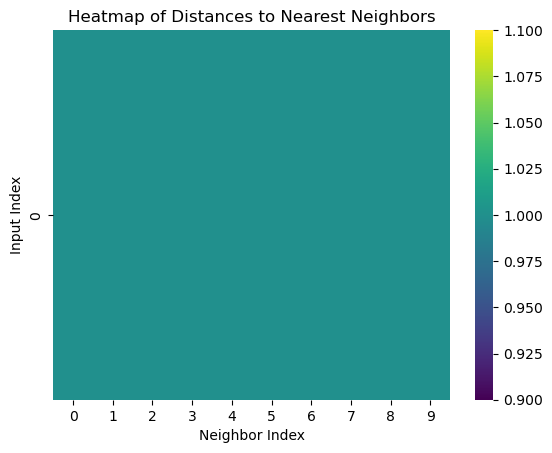

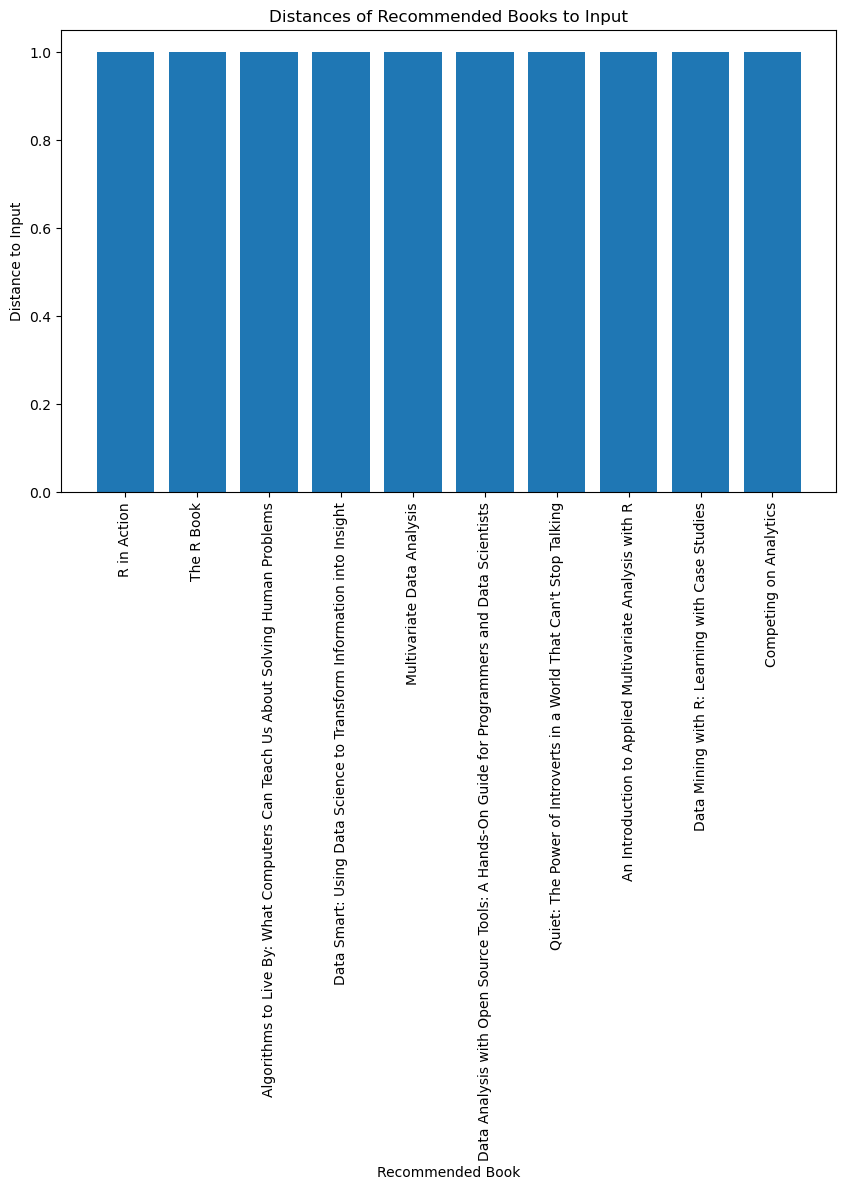

<class 'pandas.core.frame.DataFrame'>
[{'title': 'R in Action', 'rating': 4.2, 'author': 'Robert Kabacoff'}, {'title': 'The R Book', 'rating': 4.13, 'author': 'Michael J. Crawley'}, {'title': 'Algorithms to Live By: What Computers Can Teach Us About Solving Human Problems', 'rating': 4.13, 'author': 'Brian Christian'}, {'title': 'Data Smart: Using Data Science to Transform Information into Insight', 'rating': 4.12, 'author': 'John W. Foreman'}, {'title': 'Multivariate Data Analysis', 'rating': 4.09, 'author': 'Joseph F. Hair Jr.'}]


In [14]:
# testing the prediction class before pushing to MLFlow

m = bookPopularityRecommendation(tfv = tfv,
                        sparse_vector_matrix=sparse_vector_matrix,
                        df_lookup=df_lookup,
                        recommendation=recommendation)

model_input ={
    "goalname": "sajhdvjav",
    "description": "yfu",
}
model_output = m.predict(None,model_input)
print(model_output)



Setting up MLFlow Environment

In [15]:
mlflow_conda_env ={
    'name': 'mlflow-env',
    'channels': ['defaults',
                 'conda-forge'],
    'dependencies': ['python = 3.6.2',
                     'nltk = 3.8.1',
                     'nltk_data',
                    {'pip': ['mlflow==2.10.2',
                    'scikit-learn',
                    'cloudpickle=1.2.2']}
                        ]
}


In [16]:
with mlflow .start_run(run_name="Content-Based book recommendation") as run:
    mlflow.log_param("num_events_returned", 5)
    
    pyfunc.log_model(
        artifact_path = "bookPopularity_recommendation_pyfunc",
        python_model = bookPopularityRecommendation(tfv = tfv,
                        sparse_vector_matrix=sparse_vector_matrix,
                        df_lookup=df_lookup,
                        recommendation=recommendation),
        
        conda_env = mlflow_conda_env
    )
    
    run_id = run.info.run_uuid
    experiment_id = run.info.experiment_id
    
    
    mlflow.end_run() 

/Users/karthikeyans/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
